In [1]:
!pip install torch torch-geometric scikit-learn pandas tqdm



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:0000:01


In [2]:
import numpy as np
import pandas as pd 
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings


In [3]:
df=pd.read_csv('/kaggle/input/spam-dataset/V2X_Data.csv')
df

,Message ID,Source Vehicle,Destination Vehicle,Message Type,Message Content,Priority,Spam
0,1,Car A,Car B,Emergency,"Accident ahead, use caution",High,No
1,2,Car C,Car D,Roadwork,Right lane closed ahead,Medium,No
2,3,Car E,All Vehicles,Weather,Heavy rain expected,Low,No
3,4,Car F,Car G,Traffic,Slow traffic ahead,Medium,No
4,5,Car H,All Vehicles,Emergency,Vehicle stalled in left lane,High,No
...,...,...,...,...,...,...,...
933,1008,Car Y,All Vehicles,Weather,Severe thunderstorm warning,High,No
934,1009,Car Z,Car A,Hazard,"Slippery road conditions, reduce speed",Medium,No
935,1010,Car B,All Vehicles,Roadwork,Lane closures due to construction work,Medium,No
936,1011,Car C,Car D,Spam,Limited-time offer - Buy now and get a free gift!,Low,Yes


In [4]:

# Encode categorical variables
le_source = LabelEncoder()
le_dest = LabelEncoder()
le_msg_type = LabelEncoder()
le_priority = LabelEncoder()
le_spam = LabelEncoder()

df['Source_encoded'] = le_source.fit_transform(df['Source Vehicle'])
df['Dest_encoded'] = le_dest.fit_transform(df['Destination Vehicle'])
df['MsgType_encoded'] = le_msg_type.fit_transform(df['Message Type'])
df['Priority_encoded'] = le_priority.fit_transform(df['Priority'])
df['Spam_encoded'] = le_spam.fit_transform(df['Spam'])

# Step 2: Prepare BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Step 3: Create graph data
edge_index = torch.tensor([df['Source_encoded'].tolist(), df['Dest_encoded'].tolist()], dtype=torch.long)
x = torch.tensor(df[['MsgType_encoded', 'Priority_encoded']].values, dtype=torch.float)

# Process text data with BERT
encoded_input = tokenizer(df['Message Content'].tolist(), padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    bert_output = bert_model(**encoded_input)
text_features = bert_output.last_hidden_state[:, 0, :]  # Use [CLS] token representation

# Combine graph features and text features
x = torch.cat([x, text_features], dim=1)

y = torch.tensor(df['Spam_encoded'].values, dtype=torch.long)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [5]:


# Step 1: Create initial dataframe
df = pd.DataFrame({
    'x': [x_i.tolist() for x_i in x],  # Convert tensor to list for each node
    'y': y.tolist()
})

# Add edge_index as separate columns
df['source'] = edge_index[0].tolist()
df['target'] = edge_index[1].tolist()

# Step 2: Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Function to create Data object from dataframe
def create_data_from_df(df):
    x = torch.tensor(df['x'].tolist(), dtype=torch.float)
    y = torch.tensor(df['y'].tolist(), dtype=torch.long)
    edge_index = torch.tensor([df['source'].tolist(), df['target'].tolist()], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Create Data objects
train_data = create_data_from_df(train_df)
test_data = create_data_from_df(test_df)

# Create DataLoaders
train_loader = DataLoader([train_data], batch_size=10)
test_loader = DataLoader([test_data], batch_size=10)


In [7]:

# # Step 3: Define the Graph CNN model
# class GCNModel(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(GCNModel, self).__init__()
#         self.conv1 = GCNConv(input_dim, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, hidden_dim)
#         self.fc = torch.nn.Linear(hidden_dim, output_dim)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.relu(self.conv2(x, edge_index))
#         x = self.fc(x)
#         return F.log_softmax(x, dim=1)
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.nn import JumpingKnowledge

class ComplexGCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4, dropout=0.5, use_attention=True):
        super(ComplexGCNModel, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.use_attention = use_attention

        # Input layer
        self.conv_layers = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)])
        
        # Hidden layers
        for _ in range(num_layers - 1):
            if use_attention:
                self.conv_layers.append(GATConv(hidden_dim, hidden_dim, heads=8, concat=False))
            else:
                self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))

        # Batch normalization layers
        self.batch_norms = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers)
        ])

        # Jumping Knowledge layer
        self.jk = JumpingKnowledge(mode='cat')

        # Output layer
        self.fc1 = torch.nn.Linear(num_layers * hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch=None):
        h_list = []

        for i in range(self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            h_list.append(x)

        # Apply Jumping Knowledge
        x = self.jk(h_list)

        # Global pooling
        if batch is not None:
            x = global_mean_pool(x, batch)

        # Final layers
        x = F.elu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Usage:
# model = ComplexGCNModel(input_dim=x.size(1), hidden_dim=64, output_dim=2, num_layers=4, dropout=0.5, use_attention=True)

# Step 4: Initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGCNModel(input_dim=x.size(1), hidden_dim=64, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



In [8]:
# Step 5: Training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Step 6: Testing
def test(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.num_nodes
    return correct / total

# Step 7: Run the training
for epoch in range(1000):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Final evaluation
train_acc = test(train_loader)
test_acc = test(test_loader)
print(f'Final Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 000, Loss: 0.8004, Train Acc: 0.9693, Test Acc: 0.9574
Epoch: 100, Loss: 0.0005, Train Acc: 1.0000, Test Acc: 0.9628
Epoch: 200, Loss: 0.0003, Train Acc: 1.0000, Test Acc: 0.9628
Epoch: 300, Loss: 0.0012, Train Acc: 1.0000, Test Acc: 0.9574
Epoch: 400, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.9628
Epoch: 500, Loss: 0.0004, Train Acc: 1.0000, Test Acc: 0.9628
Epoch: 600, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.9628
Epoch: 700, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.9628
Epoch: 800, Loss: 0.0006, Train Acc: 1.0000, Test Acc: 0.9574
Epoch: 900, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.9628
Final Train Accuracy: 1.0000, Test Accuracy: 0.9628


Train Accuracy: 1.0000, Test Accuracy: 0.9628
Train Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Test Precision: 0.9796, Recall: 0.8889, F1: 0.9320
Train Confusion Matrix:
[[567   0]
 [  0 183]]
Test Confusion Matrix:
[[133   1]
 [  6  48]]


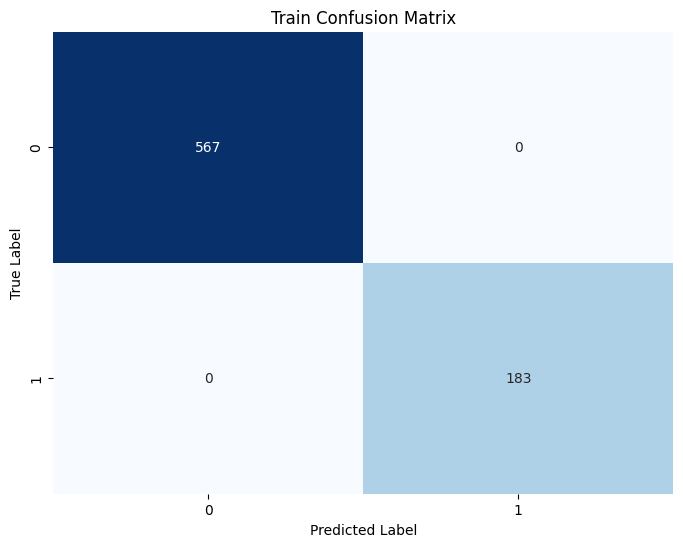

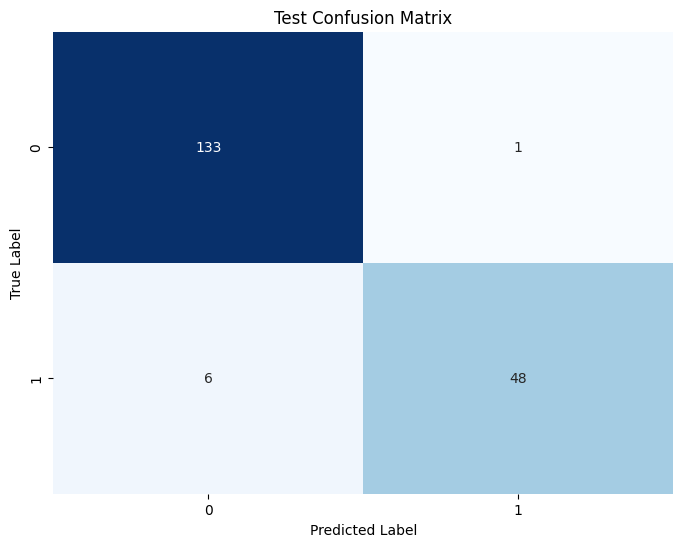

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



def evaluate(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Flatten the lists
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, cm

train_acc, train_precision, train_recall, train_f1, train_cm = evaluate(train_loader)
test_acc, test_precision, test_recall, test_f1, test_cm = evaluate(test_loader)

print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')
print(f'Train Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}')
print(f'Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
print(f'Train Confusion Matrix:\n{train_cm}')
print(f'Test Confusion Matrix:\n{test_cm}')
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# After running your evaluation code, plot the confusion matrices
plot_confusion_matrix(train_cm, title='Train Confusion Matrix')
plot_confusion_matrix(test_cm, title='Test Confusion Matrix')

## Method 2

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Epoch: 000, Loss: 0.6354, Train Acc: 0.7560, Test Acc: 0.7128
Epoch: 010, Loss: 0.0627, Train Acc: 0.9907, Test Acc: 1.0000
Epoch: 020, Loss: 0.0363, Train Acc: 0.9880, Test Acc: 0.9947
Epoch: 030, Loss: 0.0242, Train Acc: 0.9920, Test Acc: 0.9947
Epoch: 040, Loss: 0.0124, Train Acc: 0.9960, Test Acc: 1.0000
Epoch: 050, Loss: 0.0037, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 060, Loss: 0.0010, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 070, Loss: 0.0003, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 080, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 090, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 100, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 110, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 120, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 130, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 140, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 150, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 1

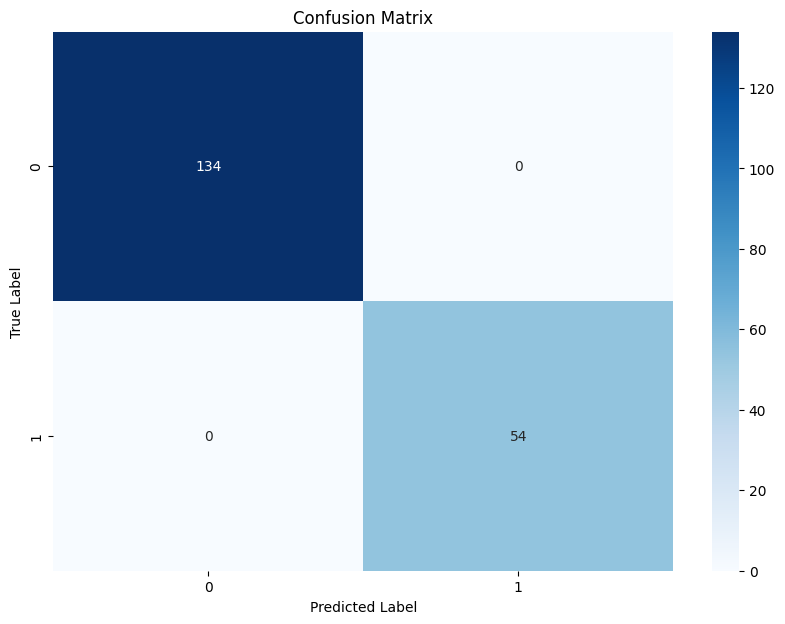

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


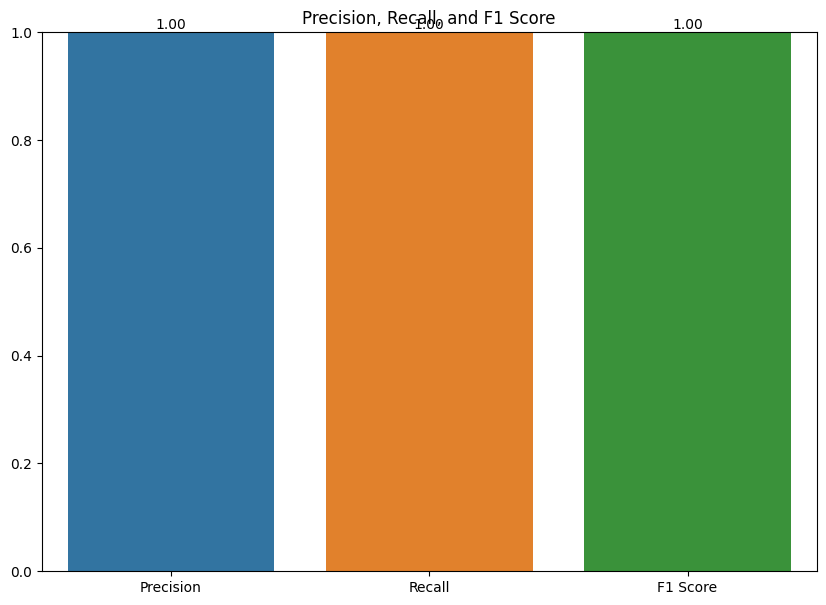

In [10]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load and preprocess the data
df=pd.read_csv('/kaggle/input/spam-dataset/V2X_Data.csv')

# Encode categorical variables
le_source = LabelEncoder()
le_dest = LabelEncoder()
le_msg_type = LabelEncoder()
le_priority = LabelEncoder()
le_spam = LabelEncoder()

df['Source_encoded'] = le_source.fit_transform(df['Source Vehicle'])
df['Dest_encoded'] = le_dest.fit_transform(df['Destination Vehicle'])
df['MsgType_encoded'] = le_msg_type.fit_transform(df['Message Type'])
df['Priority_encoded'] = le_priority.fit_transform(df['Priority'])
df['Spam_encoded'] = le_spam.fit_transform(df['Spam'])

# Step 2: Prepare BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Step 3: Create graph data
edge_index = torch.tensor([df['Source_encoded'].tolist(), df['Dest_encoded'].tolist()], dtype=torch.long)
x = torch.tensor(df[['MsgType_encoded', 'Priority_encoded']].values, dtype=torch.float)

# Process text data with BERT
encoded_input = tokenizer(df['Message Content'].tolist(), padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    bert_output = bert_model(**encoded_input)
text_features = bert_output.last_hidden_state[:, 0, :]  # Use [CLS] token representation

# Combine graph features and text features
x = torch.cat([x, text_features], dim=1)

y = torch.tensor(df['Spam_encoded'].values, dtype=torch.long)

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Step 4: Split the data
num_nodes = data.num_nodes
node_indices = list(range(num_nodes))
train_indices, test_indices = train_test_split(node_indices, test_size=0.2, random_state=42)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# Step 5: Define the Graph CNN model
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Step 6: Initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(input_dim=data.x.size(1), hidden_dim=64, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
data = data.to(device)

# Step 7: Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Step 8: Testing
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        train_correct = pred[data.train_mask] == data.y[data.train_mask]
        train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return train_acc, test_acc, pred[data.test_mask], data.y[data.test_mask]

# Step 9: Run the training
for epoch in range(200):
    loss = train()
    train_acc, test_acc, _, _ = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Step 10: Final evaluation and metrics
_, _, final_preds, final_labels = test()
final_preds = final_preds.cpu().numpy()
final_labels = final_labels.cpu().numpy()

precision, recall, f1, _ = precision_recall_fscore_support(final_labels, final_preds, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Create confusion matrix
cm = confusion_matrix(final_labels, final_preds)

# Visualize confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualize precision, recall, and F1 score
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

plt.figure(figsize=(10,7))
sns.barplot(x=metrics, y=values)
plt.title('Precision, Recall, and F1 Score')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.show()